In [ ]:
!pip install pyforest
from pyforest import *
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import sklearn.metrics
from pylab import rcParams
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
from google.colab import files
import pandas_datareader as web
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
import datetime as dt

In [ ]:
stock = ['^RUT', '^GSPC', '^DJI', '^IXIC' ]
start = pd.to_datetime('1990-01-03')
df = web.DataReader(stock, data_source = 'yahoo', start = start )
print(df.tail())

<IPython.core.display.Javascript object>

Attributes    Adj Close                                                 Close                                                  High               \
Symbols            ^RUT        ^GSPC          ^DJI         ^IXIC         ^RUT        ^GSPC          ^DJI         ^IXIC         ^RUT        ^GSPC   
Date                                                                                                                                               
2020-09-01  1578.579956  3526.649902  28645.660156  11939.669922  1578.579956  3526.649902  28645.660156  11939.669922  1578.579956  3528.030029   
2020-09-02  1592.290039  3580.840088  29100.500000  12056.440430  1592.290039  3580.840088  29100.500000  12056.440430  1595.040039  3588.110107   
2020-09-03  1544.680054  3455.060059  28292.730469  11458.099609  1544.680054  3455.060059  28292.730469  11458.099609  1592.469971  3564.850098   
2020-09-04  1535.300049  3426.959961  28133.310547  11313.129883  1535.300049  3426.959961  28133.310547  11313.

In [ ]:
data = df['Adj Close']
data.tail()

Symbols,^RUT,^GSPC,^DJI,^IXIC
Date,,,,
2020-09-01,1578.579956,3526.649902,28645.660156,11939.669922
2020-09-02,1592.290039,3580.840088,29100.500000,12056.440430
2020-09-03,1544.680054,3455.060059,28292.730469,11458.099609
2020-09-04,1535.300049,3426.959961,28133.310547,11313.129883
2020-09-08,1504.589966,3331.840088,27500.890625,10847.690430


These time-series we can visually compare in one chart after applying normalisation as follows:

<IPython.core.display.Javascript object>

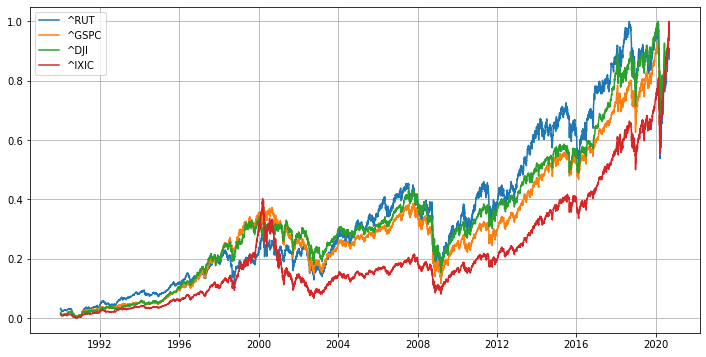

In [ ]:
from sklearn.preprocessing import MinMaxScaler
 
scaler = MinMaxScaler(feature_range=(0, 1))
sdf_np = scaler.fit_transform(data)  # note: scaler converts df into numpy array
sdf = pd.DataFrame(sdf_np, columns=data.columns, index=data.index)
 
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(sdf)
plt.legend(sdf.columns)
plt.show()

A motivation for the selection of RUT, DJI and IXIC is their pretty high correlation with GSPC. We can diagnose this by measuring the average linear correlation over the rolling window in a function of rolling window size:

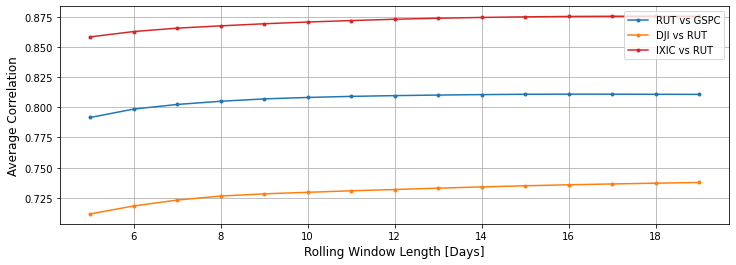

In [ ]:
blue, orange, red = '#1f77b4', '#ff7f0e', '#d62728'  # color codes
 
plt.figure(figsize=(12,4))
plt.grid()
 
avg_corr1, avg_corr2, avg_corr3 = list(), list(), list()
 
# average correlation for increasing rolling window size
for win in range(5, 20):  # Days
    avg_corr1.append(data['^GSPC'].rolling(win).corr(data['^RUT']) \
                     .replace([np.inf, -np.inf], np.nan).dropna().mean())
    avg_corr2.append(data['^DJI'].rolling(win).corr(data['^RUT']) \
                     .replace([np.inf, -np.inf], np.nan).dropna().mean())
    avg_corr3.append(data['^IXIC'].rolling(win).corr(data['^RUT']) \
                     .replace([np.inf, -np.inf], np.nan).dropna().mean())
    
plt.plot(range(5, 20), avg_corr1, '.-', color=blue, label='RUT vs GSPC')
plt.plot(range(5, 20), avg_corr2, '.-', color=orange, label='DJI vs RUT')
plt.plot(range(5, 20), avg_corr3, '.-', color=red, label='IXIC vs RUT')
 
plt.legend()
plt.xlabel('Rolling Window Length [Days]', fontsize=12)
plt.ylabel('Average Correlation', fontsize=12)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f'Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f'Significance Level = {signif}')
    print(f'Test Statistic = {output["test_statistic"]}')
    print(f'No. Lags Chosen = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")


# ADF test on each column
for name, column in data.iteritems():
  adfuller_test(column, name = column.name)

Augmented Dickey-Fuller Test on "^RUT" 
    -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test Statistic = -0.4536
No. Lags Chosen = 35
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.9008. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
Augmented Dickey-Fuller Test on "^GSPC" 
    -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test Statistic = 0.9694
No. Lags Chosen = 36
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.9939. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
Augmented Dickey-Fuller Test on "^DJI" 
    -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test Stat

Glimpse of differenced data:
Symbols         ^RUT     ^GSPC       ^DJI     ^IXIC
Date                                               
1990-01-04 -0.699997 -3.089996 -13.649902 -1.500000
1990-01-05 -0.440002 -3.470001 -22.830078 -1.199982
1990-01-08 -0.099991  1.589996  21.120117  0.500000
1990-01-09 -0.250000 -4.170013 -28.370117 -1.900024
1990-01-10 -1.360001 -2.309998 -15.360107 -6.099976


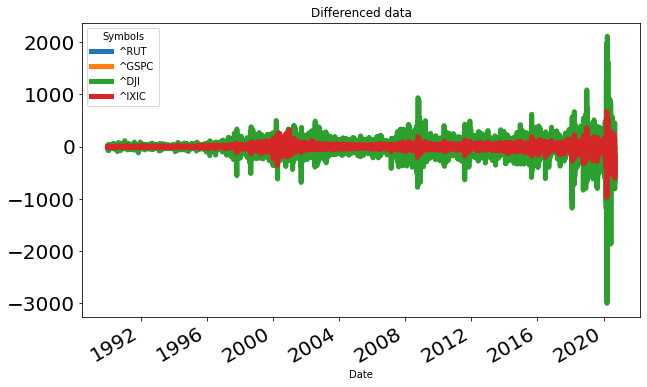

In [ ]:
nobs = 10

# differenced train data
data_diff = data.diff()
data_diff.dropna(inplace=True)
print('Glimpse of differenced data:')
print(data_diff.head())

# plotting differenced data
data_diff.plot(figsize=(10,6), linewidth=5, fontsize=20)
plt.title('Differenced data')
plt.show()

In [ ]:
# ADF Test on each column
for name, column in data_diff.iteritems():
  adfuller_test(column, name=column.name)

Augmented Dickey-Fuller Test on "^RUT" 
    -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test Statistic = -15.9429
No. Lags Chosen = 34
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
Augmented Dickey-Fuller Test on "^GSPC" 
    -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test Statistic = -15.8147
No. Lags Chosen = 35
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
Augmented Dickey-Fuller Test on "^DJI" 
    -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test Statistic = -15.8812
No. Lags Chosen = 35
 Critical

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from scipy.stats import describe
from statsmodels.tsa.api import VAR

In [ ]:
var_model = smt.VAR(data_diff)
res = var_model.select_order(maxlags=15)
print(res.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        22.29       22.29   4.778e+09       22.29
1        22.26      22.27*   4.630e+09       22.26
2        22.24       22.28   4.570e+09       22.25
3        22.24       22.28   4.545e+09       22.25
4        22.23       22.29   4.521e+09       22.25
5        22.23       22.31   4.516e+09       22.26
6        22.22       22.31   4.467e+09       22.25
7        22.20       22.31   4.391e+09       22.24
8        22.19       22.31   4.329e+09       22.23
9        22.18       22.31   4.293e+09      22.23*
10       22.18       22.32   4.276e+09       22.23
11       22.18       22.34   4.281e+09       22.23
12       22.17       22.35   4.257e+09       22.23
13       22.17       22.36   4.245e+09       22.23
14       22.17       22.37   4.235e+09       22.24
15      22.16*       22.38  4.226e+09*       22.24
-------------------------------

In [ ]:
results = var_model.fit(maxlags=15, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 09, Sep, 2020
Time:                     11:17:06
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    22.3843
Nobs:                     7715.00    HQIC:                   22.2398
Log likelihood:          -129044.    FPE:                4.22565e+09
AIC:                      22.1644    Det(Omega_mle):     4.09460e+09
--------------------------------------------------------------------
Results for equation ^RUT
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.162300         0.120354            1.349           0.177
L1.^RUT           0.060165         0.023380            2.573           0.010
L1.^GSPC         -0.092105         0.042046           -2.191           0.028


In [ ]:
from pandas import DataFrame
# forecasting
lag_order = results.k_ar
DataFrame(results.forecast(data_diff.values[-lag_order:], nobs))

,0,1,2,3
0,6.179871,18.588889,147.595192,43.208029
1,-5.793702,-2.354789,-68.875534,-12.017996
2,-1.187684,5.748262,15.235834,17.864327
3,13.074930,22.147101,153.536531,67.175911
4,-12.694413,-23.138287,-220.631382,-72.527600
5,22.751256,35.498871,301.100582,113.562426
6,-12.448735,-22.405352,-192.905542,-74.240101
7,8.915211,19.725856,178.926437,76.790436
8,-7.375306,-16.717818,-110.166912,-54.730713
9,-10.818298,-15.171361,-92.833781,-59.050177


In [ ]:
# make predictions
pred = results.forecast(results.y, steps=nobs)
print(pred)

[[   6.17987074   18.5888894   147.59519171   43.20802924]
 [  -5.79370209   -2.35478861  -68.87553394  -12.01799585]
 [  -1.18768435    5.74826186   15.23583418   17.86432683]
 [  13.07493001   22.14710091  153.53653078   67.17591102]
 [ -12.69441276  -23.13828672 -220.63138164  -72.52759958]
 [  22.75125556   35.49887053  301.10058228  113.56242586]
 [ -12.44873492  -22.40535157 -192.90554236  -74.24010096]
 [   8.91521076   19.7258563   178.92643692   76.79043622]
 [  -7.37530567  -16.71781788 -110.16691233  -54.73071346]
 [ -10.81829771  -15.1713606   -92.83378114  -59.0501772 ]]


In [ ]:
pred = pd.DataFrame(pred, columns=data.columns+ '_pred')
pred

<IPython.core.display.Javascript object>

Symbols,^RUT_pred,^GSPC_pred,^DJI_pred,^IXIC_pred
0,6.179871,18.588889,147.595192,43.208029
1,-5.793702,-2.354789,-68.875534,-12.017996
2,-1.187684,5.748262,15.235834,17.864327
3,13.074930,22.147101,153.536531,67.175911
4,-12.694413,-23.138287,-220.631382,-72.527600
5,22.751256,35.498871,301.100582,113.562426
6,-12.448735,-22.405352,-192.905542,-74.240101
7,8.915211,19.725856,178.926437,76.790436
8,-7.375306,-16.717818,-110.166912,-54.730713
9,-10.818298,-15.171361,-92.833781,-59.050177


In [ ]:
# inverting transformation
def invert_transformation(data_diff, pred):
  forecast = pred.copy()
  columns = data.columns
  for col in columns:
    forecast[str(col)+'_pred'] = data[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
    return forecast
output = invert_transformation(data_diff, pred)
output.loc[:, ['^RUT_pred']]

Symbols,^RUT_pred
0,1510.769837
1,1504.976134
2,1503.788450
3,1516.863380
4,1504.168967
5,1526.920223
6,1514.471488
7,1523.386699
8,1516.011393
9,1505.193095


In [ ]:
from pandas import DataFrame
output = DataFrame(output['^RUT_pred'])
output

,^RUT_pred
0,1510.769837
1,1504.976134
2,1503.788450
3,1516.863380
4,1504.168967
5,1526.920223
6,1514.471488
7,1523.386699
8,1516.011393
9,1505.193095


In [ ]:
d = data.tail(nobs)
d.reset_index(inplace = True)
d = d.append(pd.DataFrame({'Date': pd.date_range(start = d.Date.iloc[-1], 
                                             periods = (len(d)+1), freq = 'd', closed = 'right')}))
d.set_index('Date', inplace = True)
d = d.tail(nobs)
output.index = d.index
print(output)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

              ^RUT_pred
Date                   
2020-09-09  1510.769837
2020-09-10  1504.976134
2020-09-11  1503.788450
2020-09-12  1516.863380
2020-09-13  1504.168967
2020-09-14  1526.920223
2020-09-15  1514.471488
2020-09-16  1523.386699
2020-09-17  1516.011393
2020-09-18  1505.193095


In [ ]:
fig = go.Figure()
n = output.index[0]
fig.add_trace(go.Scatter(x = data.index[-200:], y = data['^RUT'][-200:],
                         marker = dict(color ="red"), name = "Actual close price"))
fig.add_trace(go.Scatter(x = output.index, y = output['^RUT_pred'], marker=dict(
        color = "green"), name = "Future prediction"))


fig.update_xaxes(showline = True, linewidth = 2, linecolor='black', mirror = True, showspikes = True,)
fig.update_yaxes(showline = True, linewidth = 2, linecolor='black', mirror = True, showspikes = True,)
fig.update_layout(
    title= "10 days days RUT Forecast", 
    yaxis_title = 'RUTC (US$)',
    hovermode = "x",
    hoverdistance = 100, # Distance to show hover label of data point
    spikedistance = 1000,
    shapes = [dict(
        x0 = n, x1 = n, y0 = 0, y1 = 1, xref = 'x', yref = 'paper',
        line_width = 2)],
    annotations = [dict(x = n, y = 0.05, xref = 'x', yref = 'paper', showarrow = False, 
                        xanchor = 'left', text = 'Prediction')]) 
fig.update_layout(autosize = False, width = 1000, height = 400,)
fig.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>